# Density figures

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import haversine_distances
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.neighbors import BallTree
import math
from statsmodels.stats.weightstats import DescrStatsW

In [2]:
pwd

'/efs/home/jupyter-raffo/research/toolpaper'

In [3]:
r_km = 6378.137 # 6371 # multiplier to convert to km (from unit distance)

# pubs

In [81]:
df = pd.read_csv('isp0313.csv')
df.head()

,year,lat,lng,tec,wgt,adminlat,adminlng,name,admin1,admin2,cc
0,2003,-54.8,-68.3,1,3.500000,-54.8,-68.3,Ushuaia,Tierra del Fuego,NaN,AR
1,2003,-54.8,-68.3,2,0.250000,-54.8,-68.3,Ushuaia,Tierra del Fuego,NaN,AR
2,2003,-54.8,-68.3,4,0.500000,-54.8,-68.3,Ushuaia,Tierra del Fuego,NaN,AR
3,2003,-54.8,-68.3,5,3.845238,-54.8,-68.3,Ushuaia,Tierra del Fuego,NaN,AR
4,2003,-54.8,-68.3,7,0.250000,-54.8,-68.3,Ushuaia,Tierra del Fuego,NaN,AR


In [82]:
dfall = df[['year','lat','lng','wgt']].groupby(['year','lat','lng'],as_index=False).sum()
# dfall = dfall.drop(columns = ['tec'])
dfall.head()

,year,lat,lng,wgt
0,2003,-54.80000,-68.30000,8.345238
1,2003,-53.15483,-70.91129,3.111111
2,2003,-51.62261,-69.21813,1.333333
3,2003,-51.39400,-70.60550,4.250000
4,2003,-47.75034,-65.89382,0.333333


In [83]:
dfcc = df[['year','lat','lng','wgt','cc']].groupby(['year','lat','lng','cc'],as_index=False).sum()
dfcc.head()

,year,lat,lng,cc,wgt
0,2003,-54.80000,-68.30000,AR,8.345238
1,2003,-53.15483,-70.91129,CL,3.111111
2,2003,-51.62261,-69.21813,AR,1.333333
3,2003,-51.39400,-70.60550,AR,4.250000
4,2003,-47.75034,-65.89382,AR,0.333333


In [84]:
for x in df, dfall, dfcc:
    # round up wgts
    x['wgt']=x['wgt'].apply(np.ceil)
    # convert coords to radians 
    x['radlat']=np.deg2rad(x['lat'].values)
    x['radlng']=np.deg2rad(x['lng'].values)
    print(x.head())
    print('total wgts:', x.wgt.sum())
    # print('unwgt stats:', x.describe())

   year   lat   lng  tec  wgt  adminlat  adminlng     name            admin1  \
0  2003 -54.8 -68.3    1  4.0     -54.8     -68.3  Ushuaia  Tierra del Fuego   
1  2003 -54.8 -68.3    2  1.0     -54.8     -68.3  Ushuaia  Tierra del Fuego   
2  2003 -54.8 -68.3    4  1.0     -54.8     -68.3  Ushuaia  Tierra del Fuego   
3  2003 -54.8 -68.3    5  4.0     -54.8     -68.3  Ushuaia  Tierra del Fuego   
4  2003 -54.8 -68.3    7  1.0     -54.8     -68.3  Ushuaia  Tierra del Fuego   

  admin2  cc   radlat   radlng  
0    NaN  AR -0.95644 -1.19206  
1    NaN  AR -0.95644 -1.19206  
2    NaN  AR -0.95644 -1.19206  
3    NaN  AR -0.95644 -1.19206  
4    NaN  AR -0.95644 -1.19206  
total wgts: 2585321.0
   year       lat       lng  wgt    radlat    radlng
0  2003 -54.80000 -68.30000  9.0 -0.956440 -1.192060
1  2003 -53.15483 -70.91129  4.0 -0.927727 -1.237635
2  2003 -51.62261 -69.21813  2.0 -0.900985 -1.208084
3  2003 -51.39400 -70.60550  5.0 -0.896995 -1.232298
4  2003 -47.75034 -65.89382  1.0 -

## data for minden overtime

In [13]:
myeps = 15
for t in 2003, 2013:
    print(t)
    x = dfall[dfall['year']==t].copy()
    tree = BallTree(x[['radlat','radlng']], leaf_size=10, metric='haversine', sample_weight=x.wgt)
    radius = myeps /r_km    
    N=tree.query_radius(x[['radlat','radlng']], r=radius, count_only=True)
    # Min Density
    x['minden']=(N/np.pi/(myeps**2)).tolist()
    wdf = DescrStatsW(x.minden, weights=x.wgt, ddof=1) 
    curminden = pd.DataFrame(wdf.quantile(np.linspace(0,1,101)))
    curminden.rename(columns={0:'minden'+str(t)}, inplace=True)
    try:
        tmp = pd.concat([tmp,curminden], axis=1)
    except:
        tmp  = curminden
    # Min Pts
    x['minpts']=N.tolist()
    wdf2 = DescrStatsW(x.minpts, weights=x.wgt, ddof=1) 
    curminpts = pd.DataFrame(wdf2.quantile(np.linspace(0,1,101)))
    curminpts.rename(columns={0:'minpts'+str(t)}, inplace=True)
    try:
        tmp2 = pd.concat([tmp2,curminpts], axis=1)
    except:
        tmp2  = curminpts
minden = tmp
del tmp
minpts = tmp2
del tmp2
minden.to_csv('plots/mindenpubs0313/mindenpubs.csv', index=True)
minpts.to_csv('plots/mindenpubs0313/minptspubs.csv', index=True)

2003
2013


In [14]:
minden

,minden2003,minden2013
p,,
0.00,0.001415,0.001415
0.01,0.001415,0.001415
0.02,0.001415,0.001415
0.03,0.001415,0.001415
0.04,0.002829,0.001415
...,...,...
0.96,0.244745,0.248989
0.97,0.372069,0.287186
0.98,0.621058,0.539005


## data minden over tecs

In [45]:
np.sort(df.tec.unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [50]:
myeps = 15
t= 2013

for i in np.sort(df.tec.unique()):
    print(i)
    x = df[(df['year']==t) & (df['tec']==i)].copy()    
    tree = BallTree(x[['radlat','radlng']], leaf_size=10, metric='haversine', sample_weight=x.wgt)
    radius = myeps /r_km    
    N=tree.query_radius(x[['radlat','radlng']], r=radius, count_only=True)
    # Min Density
    x['minden']=(N/np.pi/(myeps**2)).tolist()
    wdf = DescrStatsW(x.minden, weights=x.wgt, ddof=1) 
    curminden = pd.DataFrame(wdf.quantile(np.linspace(0,1,101)))
    curminden.rename(columns={0:'minden'+str(t)+str(i)}, inplace=True)
    try:
        tmp = pd.concat([tmp,curminden], axis=1)
    except:
        tmp  = curminden
    # Min Pts
    x['minpts']=N.tolist()
    wdf2 = DescrStatsW(x.minpts, weights=x.wgt, ddof=1) 
    curminpts = pd.DataFrame(wdf2.quantile(np.linspace(0,1,101)))
    curminpts.rename(columns={0:'minpts'+str(t)+str(i)}, inplace=True)
    try:
        tmp2 = pd.concat([tmp2,curminpts], axis=1)
    except:
        tmp2  = curminpts
minden = tmp
del tmp
minpts = tmp2
del tmp2
minden.to_csv('plots/mindenpubs0313/mindenpubstecs.csv', index=True)
minpts.to_csv('plots/mindenpubs0313/minptspubstecs.csv', index=True)

0
1
2
3
4
5
6
7
8
9
10
11
12


## data minden over CCs

In [53]:
dfcc.head()

,year,lat,lng,cc,wgt,radlat,radlng
0,2003,-54.80000,-68.30000,AR,9.0,-0.956440,-1.192060
1,2003,-53.15483,-70.91129,CL,4.0,-0.927727,-1.237635
2,2003,-51.62261,-69.21813,AR,2.0,-0.900985,-1.208084
3,2003,-51.39400,-70.60550,AR,5.0,-0.896995,-1.232298
4,2003,-47.75034,-65.89382,AR,1.0,-0.833401,-1.150064


In [57]:
myeps = 15
t= 2013
cclist = ['AR','AU','BR','CN','DE','FR','GB','JP', 'MX', 'SG', 'US','ZA']
for c in np.sort(cclist):
    print(c)
    x = dfcc[(dfcc['year']==t) & (dfcc['cc']==c)].copy()    
    tree = BallTree(x[['radlat','radlng']], leaf_size=10, metric='haversine', sample_weight=x.wgt)
    radius = myeps /r_km    
    N=tree.query_radius(x[['radlat','radlng']], r=radius, count_only=True)
    # Min Density
    x['minden']=(N/np.pi/(myeps**2)).tolist()
    wdf = DescrStatsW(x.minden, weights=x.wgt, ddof=1) 
    curminden = pd.DataFrame(wdf.quantile(np.linspace(0,1,101)))
    curminden.rename(columns={0:'minden'+str(t)+str(c)}, inplace=True)
    try:
        tmp = pd.concat([tmp,curminden], axis=1)
    except:
        tmp  = curminden
    # Min Pts
    x['minpts']=N.tolist()
    wdf2 = DescrStatsW(x.minpts, weights=x.wgt, ddof=1) 
    curminpts = pd.DataFrame(wdf2.quantile(np.linspace(0,1,101)))
    curminpts.rename(columns={0:'minpts'+str(t)+str(c)}, inplace=True)
    try:
        tmp2 = pd.concat([tmp2,curminpts], axis=1)
    except:
        tmp2  = curminpts
minden = tmp
del tmp
minpts = tmp2
del tmp2
minden.to_csv('plots/mindenpubs0313/mindenpubscc.csv', index=True)
minpts.to_csv('plots/mindenpubs0313/minptspubscc.csv', index=True)

AR
AU
BR
CN
DE
FR
GB
JP
MX
SG
US
ZA


In [58]:
minden

,minden2013AR,minden2013AU,minden2013BR,minden2013CN,minden2013DE,minden2013FR,minden2013GB,minden2013JP,minden2013MX,minden2013SG,minden2013US,minden2013ZA
p,,,,,,,,,,,,
0.00,0.001415,0.001415,0.001415,0.001415,0.001415,0.001415,0.001415,0.001415,0.001415,0.024050,0.001415,0.001415
0.01,0.001415,0.001415,0.001415,0.002829,0.002829,0.002829,0.004244,0.004244,0.001415,0.048100,0.001415,0.001415
0.02,0.001415,0.002829,0.001415,0.002829,0.002829,0.004244,0.009903,0.005659,0.001415,0.079224,0.002829,0.001415
0.03,0.001415,0.002829,0.001415,0.004244,0.002829,0.004244,0.012732,0.008488,0.001415,0.079224,0.004244,0.001415
0.04,0.001415,0.002829,0.001415,0.005659,0.004244,0.004244,0.012732,0.009903,0.001415,0.079224,0.004244,0.001415
...,...,...,...,...,...,...,...,...,...,...,...,...
0.96,0.046685,0.151374,0.101859,0.117421,0.192401,0.251818,1.065277,0.697452,0.094786,0.084883,0.159862,0.024050
0.97,0.046685,0.151374,0.101859,0.117421,0.192401,0.251818,1.065277,0.697452,0.101859,0.084883,0.188157,0.024050
0.98,0.046685,0.151374,0.101859,0.121665,0.192401,0.251818,1.065277,0.697452,0.103274,0.084883,0.216451,0.024050


## Data for minden over epsilons

In [85]:
x = dfall[dfall['year']==2013].copy()
tree = BallTree(x[['radlat','radlng']], leaf_size=10, metric='haversine', sample_weight=x.wgt)

for myeps in 5, 10, 15, 20, 25, 30, 50, 100 : 
    print(myeps)
    radius = myeps /r_km    
    N=tree.query_radius(x[['radlat','radlng']], r=radius, count_only=True)
    # Min Density
    x['minden']=(N/np.pi/(myeps**2)).tolist()
    wdf = DescrStatsW(x.minden, weights=x.wgt, ddof=1) 
    curminden = pd.DataFrame(wdf.quantile(np.linspace(0,1,101)))
    curminden.rename(columns={0:'eps'+str(myeps)}, inplace=True)
    try:
        tmp = pd.concat([tmp,curminden], axis=1)
    except:
        tmp  = curminden
    # Min Pts
    x['minpts']=N.tolist()
    wdf2 = DescrStatsW(x.minpts, weights=x.wgt, ddof=1) 
    curminpts = pd.DataFrame(wdf2.quantile(np.linspace(0,1,101)))
    curminpts.rename(columns={0:'eps'+str(myeps)}, inplace=True)
    try:
        tmp2 = pd.concat([tmp2,curminpts], axis=1)
    except:
        tmp2  = curminpts
    
minden = tmp
del tmp
minpts = tmp2
del tmp2
minden.to_csv('plots/mindenpubs0313/mindenpubeps.csv', index=True)
minpts.to_csv('plots/mindenpubs0313/minptspubeps.csv', index=True)

5
10
15
20
25
30
50
100


In [86]:
print(minden.head())
print(minpts.head())

          eps5     eps10     eps15     eps20     eps25     eps30     eps50  \
p                                                                            
0.00  0.012732  0.003183  0.001415  0.000796  0.000509  0.000354  0.000127   
0.01  0.012732  0.003183  0.001415  0.000796  0.000509  0.000354  0.000127   
0.02  0.012732  0.003183  0.001415  0.000796  0.000509  0.000354  0.000255   
0.03  0.012732  0.003183  0.001415  0.000796  0.000509  0.000707  0.000382   
0.04  0.012732  0.003183  0.001415  0.001592  0.001019  0.000707  0.000509   

        eps100  
p               
0.00  0.000032  
0.01  0.000095  
0.02  0.000159  
0.03  0.000191  
0.04  0.000255  
      eps5  eps10  eps15  eps20  eps25  eps30  eps50  eps100
p                                                           
0.00     1      1      1      1      1      1      1       1
0.01     1      1      1      1      1      1      1       3
0.02     1      1      1      1      1      1      2       5
0.03     1      1      1     

In [123]:
nobswgt = x.wgt.sum()
nobswgt

1517415.0

In [124]:
limeps = 60 
restmp = pd.DataFrame(columns = ['epsilon', 'radius', 'minden', 'minpts', 'n_clusters', 'cluster_share', 'conc_coeff'])
for myeps in range(1, limeps+1, 1) : 
    radius = myeps /r_km    
    N=tree.query_radius(x[['radlat','radlng']], r=radius, count_only=True)
    x['minden']=(N/np.pi/(myeps**2)).tolist()
    wdf0 = DescrStatsW(x.minden, weights=x.wgt, ddof=1)
    curminden = wdf0.quantile([0.50]).values[0] 
    x['minpts']=N.tolist()
    wdf = DescrStatsW(x.minpts, weights=x.wgt, ddof=1)
    curminpts = int(np.ceil(wdf.quantile([0.50])))
    db = DBSCAN(eps=radius, min_samples=curminpts, algorithm='ball_tree', metric='haversine').fit(x[['radlat','radlng']], sample_weight=x.wgt)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    # n_noise = list(labels).count(-1)
    x['labels']=labels.tolist()
    n_noise = x[x['labels']==-1].wgt.sum()
    noise_share = (n_noise/nobswgt)*100
    cluster_share = 100-noise_share
    conc_coeff = (cluster_share/(50))-1
    print(myeps, radius, curminden, curminpts, n_clusters, cluster_share, conc_coeff)
    restmp = pd.concat([restmp, pd.DataFrame.from_records([{
        'epsilon' : myeps, 
        'radius': radius, 
        'minden': curminden, 
        'minpts' : curminpts, 
        'n_clusters' : n_clusters, 
        'cluster_share' : cluster_share/100,
        'conc_coeff' : conc_coeff}])], ignore_index = True)
        

1 0.0001567855942887398 0.6366197723675814 2 20890 99.01760559899566 0.9803521119799132
2 0.0003135711885774796 0.15915494309189535 2 17574 99.19876895905207 0.9839753791810415
3 0.0004703567828662194 0.1414710605261292 4 9799 98.5225531578375 0.9704510631567502
4 0.0006271423771549592 0.0994718394324346 5 7449 98.45362013687752 0.9690724027375504
5 0.000783927971443699 0.0891267681314614 7 5570 98.2490617266865 0.9649812345337301
6 0.0009407135657324388 0.07957747154594767 9 4571 98.13182286981478 0.9626364573962958
7 0.0010974991600211786 0.0649612012619981 10 4029 98.16075365012209 0.9632150730024418
8 0.0012542847543099184 0.05968310365946075 12 3502 98.06644853253724 0.9613289706507446
9 0.0014110703485986583 0.055016523537939135 14 3116 97.98749847602666 0.9597499695205332
10 0.001567855942887398 0.047746482927568605 15 2899 98.02466695004333 0.9604933390008665
11 0.0017246415371761378 0.044721223678714395 17 2663 97.97168210410467 0.9594336420820935
12 0.0018814271314648776 0.03

In [125]:
respubs = restmp
restmp.head()

,epsilon,radius,minden,minpts,n_clusters,cluster_share,conc_coeff
0,1,0.000157,0.636620,2,20890,0.990176,0.980352
1,2,0.000314,0.159155,2,17574,0.991988,0.983975
2,3,0.000470,0.141471,4,9799,0.985226,0.970451
3,4,0.000627,0.099472,5,7449,0.984536,0.969072
4,5,0.000784,0.089127,7,5570,0.982491,0.964981


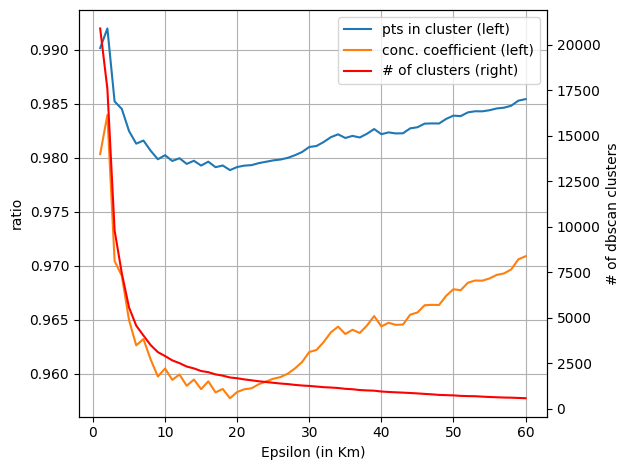

In [128]:
fig = plt.figure()
ax = fig.add_subplot(111)

lns1 = ax.plot(respubs['epsilon'], respubs['cluster_share'], '-', label = 'pts in cluster (left)')
lns2 = ax.plot(respubs['epsilon'], respubs['conc_coeff'], '-', label = 'conc. coefficient (left)')
ax2 = ax.twinx()
lns3 = ax2.plot(respubs['epsilon'], respubs['n_clusters'], '-r', label = '# of clusters (right)')

# added these three lines
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
ax.grid()
ax.set_xlabel("Epsilon (in Km)")
ax.set_ylabel('ratio')
ax2.set_ylabel('# of dbscan clusters')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.savefig('plots/fig3d_pts_pubs_eps.png')
plt.show()

<Figure size 640x480 with 0 Axes>

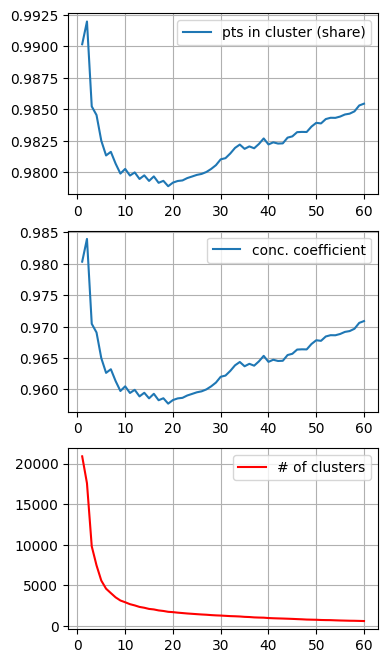

In [130]:
fig = plt.figure()
plt.figure(figsize=(4, 8))
plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.subplot(3,1,1)
plt.plot(respubs['epsilon'], respubs['cluster_share'], '-', label = 'pts in cluster (share)')
plt.grid()
plt.legend()
plt.subplot(3,1,2)
plt.plot(respubs['epsilon'], respubs['conc_coeff'], '-', label = 'conc. coefficient')
plt.grid()
plt.legend()
plt.subplot(3,1,3)
plt.plot(respubs['epsilon'], respubs['n_clusters'], '-r', label = '# of clusters')
plt.grid()
plt.legend()
# plt.savefig('plots/fig3d_pts_pubs_eps.png')
plt.show()

In [67]:
restmp.head()

,epsilon,radius,minden,minpts,n_clusters,cluster_share,conc_coeff
0,1,0.000157,0.636620,2,20890,0.990176,0.980352
1,2,0.000314,0.159155,2,17574,0.991988,0.983975
2,3,0.000470,0.141471,4,9799,0.985226,0.970451
3,4,0.000627,0.099472,5,7449,0.984536,0.969072
4,5,0.000784,0.089127,7,5570,0.982491,0.964981


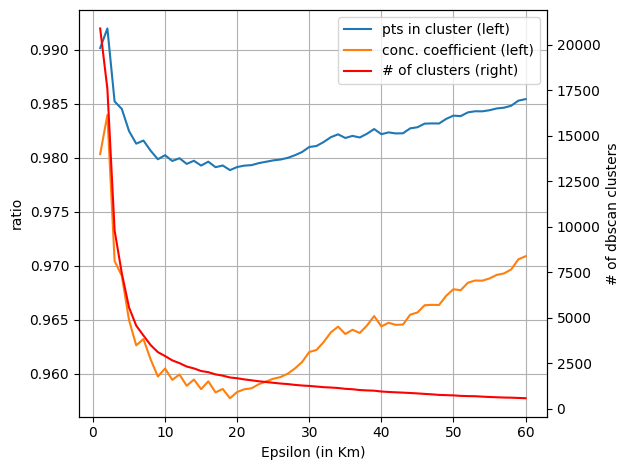

In [86]:
fig = plt.figure()
ax = fig.add_subplot(111)

lns1 = ax.plot(restmp['epsilon'], restmp['cluster_share'], '-', label = 'pts in cluster (left)')
lns2 = ax.plot(restmp['epsilon'], restmp['conc_coeff'], '-', label = 'conc. coefficient (left)')
ax2 = ax.twinx()
lns3 = ax2.plot(restmp['epsilon'], restmp['n_clusters'], '-r', label = '# of clusters (right)')

# added these three lines
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
ax.grid()
ax.set_xlabel("Epsilon (in Km)")
ax.set_ylabel('ratio')
ax2.set_ylabel('# of dbscan clusters')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.savefig('plots/fig3d_pts_pubs_eps.png')
plt.show()

# pats

In [87]:
df = pd.read_csv('ipf0313tec2.csv')
df.rename(columns={'tec2': 'tec'}, inplace=True)
df.head()

,year,lat,lng,tec,wgt,adminlat,adminlng,name,admin1,admin2,cc
0,2003,-46.40000,168.35001,14,0.250000,-46.40000,168.35000,Invercargill,Southland,Invercargill City,NZ
1,2003,-46.40000,168.35001,32,0.250000,-46.40000,168.35000,Invercargill,Southland,Invercargill City,NZ
2,2003,-46.23148,169.75117,34,0.500000,-46.23389,169.75000,Balclutha,Otago,Clutha District,NZ
3,2003,-46.23148,169.75117,41,0.500000,-46.23389,169.75000,Balclutha,Otago,Clutha District,NZ
4,2003,-46.13330,167.68300,42,0.333333,-46.35000,168.01667,Riverton,Southland,Southland District,NZ


In [88]:
dfall = df[['year','lat','lng','wgt']].groupby(['year','lat','lng'],as_index=False).sum()
# dfall = dfall.drop(columns = ['tec'])
dfall.head()

,year,lat,lng,wgt
0,2003,-46.40000,168.35001,0.500000
1,2003,-46.23148,169.75117,1.000000
2,2003,-46.13330,167.68300,0.333333
3,2003,-46.09880,168.94600,0.333333
4,2003,-46.08330,168.05000,0.333333


In [89]:
dfcc = df[['year','lat','lng','wgt','cc']].groupby(['year','lat','lng','cc'],as_index=False).sum()
dfcc.head()

,year,lat,lng,cc,wgt
0,2003,-46.40000,168.35001,NZ,0.500000
1,2003,-46.23148,169.75117,NZ,1.000000
2,2003,-46.13330,167.68300,NZ,0.333333
3,2003,-46.09880,168.94600,NZ,0.333333
4,2003,-46.08330,168.05000,NZ,0.333333


In [90]:
for x in df, dfall, dfcc:
    # round up wgts
    x['wgt']=x['wgt'].apply(np.ceil)
    # convert coords to radians 
    x['radlat']=np.deg2rad(x['lat'].values)
    x['radlng']=np.deg2rad(x['lng'].values)
    print(x.head())
    print('total wgts:', x.wgt.sum())
    # print('unwgt stats:', x.describe())

   year       lat        lng  tec  wgt  adminlat   adminlng          name  \
0  2003 -46.40000  168.35001   14  1.0 -46.40000  168.35000  Invercargill   
1  2003 -46.40000  168.35001   32  1.0 -46.40000  168.35000  Invercargill   
2  2003 -46.23148  169.75117   34  1.0 -46.23389  169.75000     Balclutha   
3  2003 -46.23148  169.75117   41  1.0 -46.23389  169.75000     Balclutha   
4  2003 -46.13330  167.68300   42  1.0 -46.35000  168.01667      Riverton   

      admin1              admin2  cc    radlat    radlng  
0  Southland   Invercargill City  NZ -0.809833  2.938262  
1  Southland   Invercargill City  NZ -0.809833  2.938262  
2      Otago     Clutha District  NZ -0.806892  2.962717  
3      Otago     Clutha District  NZ -0.806892  2.962717  
4  Southland  Southland District  NZ -0.805178  2.926620  
total wgts: 1037548.0
   year       lat        lng  wgt    radlat    radlng
0  2003 -46.40000  168.35001  1.0 -0.809833  2.938262
1  2003 -46.23148  169.75117  1.0 -0.806892  2.962717

## data for minden overtime

In [91]:
myeps = 15
for t in 2003, 2013:
    print(t)
    x = dfall[dfall['year']==t].copy()
    tree = BallTree(x[['radlat','radlng']], leaf_size=10, metric='haversine', sample_weight=x.wgt)
    radius = myeps /r_km    
    N=tree.query_radius(x[['radlat','radlng']], r=radius, count_only=True)
    # Min Density
    x['minden']=(N/np.pi/(myeps**2)).tolist()
    wdf = DescrStatsW(x.minden, weights=x.wgt, ddof=1) 
    curminden = pd.DataFrame(wdf.quantile(np.linspace(0,1,101)))
    curminden.rename(columns={0:'minden'+str(t)}, inplace=True)
    try:
        tmp = pd.concat([tmp,curminden], axis=1)
    except:
        tmp  = curminden
    # Min Pts
    x['minpts']=N.tolist()
    wdf2 = DescrStatsW(x.minpts, weights=x.wgt, ddof=1) 
    curminpts = pd.DataFrame(wdf2.quantile(np.linspace(0,1,101)))
    curminpts.rename(columns={0:'minpts'+str(t)}, inplace=True)
    try:
        tmp2 = pd.concat([tmp2,curminpts], axis=1)
    except:
        tmp2  = curminpts
minden = tmp
del tmp
minpts = tmp2
del tmp2
minden.to_csv('plots/mindenpats0313/mindenpats.csv', index=True)
minpts.to_csv('plots/mindenpats0313/minptspats.csv', index=True)

2003
2013


In [75]:
minden

,minden2003,minden2013
p,,
0.00,0.001415,0.001415
0.01,0.001415,0.001415
0.02,0.002829,0.002829
0.03,0.002829,0.002829
0.04,0.004244,0.004244
...,...,...
0.96,3.518385,2.440376
0.97,3.576388,2.523844
0.98,3.624489,2.533747


## data minden over 13 tecs 

In [76]:
np.sort(df.tec.unique())

array([ 0, 11, 12, 13, 14, 21, 31, 32, 33, 34, 41, 42, 51, 52])

In [77]:
myeps = 15
t= 2013

for i in np.sort(df.tec.unique()):
    print(i)
    x = df[(df['year']==t) & (df['tec']==i)].copy()    
    tree = BallTree(x[['radlat','radlng']], leaf_size=10, metric='haversine', sample_weight=x.wgt)
    radius = myeps /r_km    
    N=tree.query_radius(x[['radlat','radlng']], r=radius, count_only=True)
    # Min Density
    x['minden']=(N/np.pi/(myeps**2)).tolist()
    wdf = DescrStatsW(x.minden, weights=x.wgt, ddof=1) 
    curminden = pd.DataFrame(wdf.quantile(np.linspace(0,1,101)))
    curminden.rename(columns={0:'minden'+str(t)+str(i)}, inplace=True)
    try:
        tmp = pd.concat([tmp,curminden], axis=1)
    except:
        tmp  = curminden
    # Min Pts
    x['minpts']=N.tolist()
    wdf2 = DescrStatsW(x.minpts, weights=x.wgt, ddof=1) 
    curminpts = pd.DataFrame(wdf2.quantile(np.linspace(0,1,101)))
    curminpts.rename(columns={0:'minpts'+str(t)+str(i)}, inplace=True)
    try:
        tmp2 = pd.concat([tmp2,curminpts], axis=1)
    except:
        tmp2  = curminpts
minden = tmp
del tmp
minpts = tmp2
del tmp2
minden.to_csv('plots/mindenpats0313/mindenpatstecs.csv', index=True)
minpts.to_csv('plots/mindenpats0313/minptspatstecs.csv', index=True)

0
11
12
13
14
21
31
32
33
34
41
42
51
52


## data minden over CCs

In [78]:
dfcc.head()

,year,lat,lng,cc,wgt,radlat,radlng
0,2003,-46.40000,168.35001,NZ,1.0,-0.809833,2.938262
1,2003,-46.23148,169.75117,NZ,1.0,-0.806892,2.962717
2,2003,-46.13330,167.68300,NZ,1.0,-0.805178,2.926620
3,2003,-46.09880,168.94600,NZ,1.0,-0.804576,2.948664
4,2003,-46.08330,168.05000,NZ,1.0,-0.804305,2.933026


In [79]:
myeps = 15
t= 2013
cclist = ['AR','AU','BR','CN','DE','FR','GB','JP', 'MX', 'SG', 'US','ZA']
for c in np.sort(cclist):
    print(c)
    x = dfcc[(dfcc['year']==t) & (dfcc['cc']==c)].copy()    
    tree = BallTree(x[['radlat','radlng']], leaf_size=10, metric='haversine', sample_weight=x.wgt)
    radius = myeps /r_km    
    N=tree.query_radius(x[['radlat','radlng']], r=radius, count_only=True)
    # Min Density
    x['minden']=(N/np.pi/(myeps**2)).tolist()
    wdf = DescrStatsW(x.minden, weights=x.wgt, ddof=1) 
    curminden = pd.DataFrame(wdf.quantile(np.linspace(0,1,101)))
    curminden.rename(columns={0:'minden'+str(t)+str(c)}, inplace=True)
    try:
        tmp = pd.concat([tmp,curminden], axis=1)
    except:
        tmp  = curminden
    # Min Pts
    x['minpts']=N.tolist()
    wdf2 = DescrStatsW(x.minpts, weights=x.wgt, ddof=1) 
    curminpts = pd.DataFrame(wdf2.quantile(np.linspace(0,1,101)))
    curminpts.rename(columns={0:'minpts'+str(t)+str(c)}, inplace=True)
    try:
        tmp2 = pd.concat([tmp2,curminpts], axis=1)
    except:
        tmp2  = curminpts
minden = tmp
del tmp
minpts = tmp2
del tmp2
minden.to_csv('plots/mindenpats0313/mindenpatscc.csv', index=True)
minpts.to_csv('plots/mindenpats0313/minptspatscc.csv', index=True)

AR
AU
BR
CN
DE
FR
GB
JP
MX
SG
US
ZA


In [80]:
minden

,minden2013AR,minden2013AU,minden2013BR,minden2013CN,minden2013DE,minden2013FR,minden2013GB,minden2013JP,minden2013MX,minden2013SG,minden2013US,minden2013ZA
p,,,,,,,,,,,,
0.00,0.001415,0.001415,0.001415,0.001415,0.001415,0.001415,0.001415,0.001415,0.001415,0.016977,0.001415,0.001415
0.01,0.001415,0.001415,0.001415,0.001415,0.008488,0.001415,0.004244,0.009903,0.001415,0.226354,0.001415,0.001415
0.02,0.001415,0.001415,0.001415,0.001415,0.011318,0.002829,0.005659,0.016977,0.001415,0.251818,0.002829,0.001415
0.03,0.001415,0.001415,0.001415,0.001415,0.015562,0.004244,0.008488,0.025465,0.001415,0.292845,0.002829,0.001415
0.04,0.001415,0.001415,0.001415,0.001415,0.018391,0.005659,0.011318,0.029709,0.001415,0.312651,0.004244,0.001415
...,...,...,...,...,...,...,...,...,...,...,...,...
0.96,0.049515,0.389045,0.217865,0.476757,0.879950,2.021621,0.957759,2.618629,0.091956,0.527687,0.417340,0.038197
0.97,0.049515,0.391875,0.222110,0.476757,0.918147,2.034354,0.960589,2.618629,0.096200,0.527687,0.462610,0.038197
0.98,0.050930,0.398948,0.222110,0.476757,0.940783,2.042842,0.973321,2.621459,0.097615,0.527687,0.503637,0.039612


## data minden eps

In [93]:
x = dfall[dfall['year']==2013].copy()
tree = BallTree(x[['radlat','radlng']], leaf_size=10, metric='haversine', sample_weight=x.wgt)

for myeps in 5, 10, 15, 20, 25, 30, 50, 100 : 
    print(myeps)
    radius = myeps /r_km    
    N=tree.query_radius(x[['radlat','radlng']], r=radius, count_only=True)
    # Min Density
    x['minden']=(N/np.pi/(myeps**2)).tolist()
    wdf = DescrStatsW(x.minden, weights=x.wgt, ddof=1) 
    curminden = pd.DataFrame(wdf.quantile(np.linspace(0,1,101)))
    curminden.rename(columns={0:'eps'+str(myeps)}, inplace=True)
    try:
        tmp = pd.concat([tmp,curminden], axis=1)
    except:
        tmp  = curminden
    # Min Pts
    x['minpts']=N.tolist()
    wdf2 = DescrStatsW(x.minpts, weights=x.wgt, ddof=1) 
    curminpts = pd.DataFrame(wdf2.quantile(np.linspace(0,1,101)))
    curminpts.rename(columns={0:'eps'+str(myeps)}, inplace=True)
    try:
        tmp2 = pd.concat([tmp2,curminpts], axis=1)
    except:
        tmp2  = curminpts
    
minden = tmp
del tmp
minpts = tmp2
del tmp2
minden.to_csv('plots/mindenpats0313/mindenpateps.csv', index=True)
minpts.to_csv('plots/mindenpats0313/minptspateps.csv', index=True)

5
10
15
20
25
30
50
100


In [94]:
print(minden.head())
print(minpts.head())

          eps5     eps10     eps15     eps20     eps25     eps30     eps50  \
p                                                                            
0.00  0.012732  0.003183  0.001415  0.000796  0.000509  0.000354  0.000127   
0.01  0.012732  0.003183  0.001415  0.000796  0.001019  0.000707  0.000509   
0.02  0.012732  0.003183  0.002829  0.001592  0.001528  0.001415  0.001019   
0.03  0.012732  0.006366  0.002829  0.002387  0.002546  0.002122  0.001655   
0.04  0.012732  0.006366  0.004244  0.003979  0.003565  0.002829  0.002292   

        eps100  
p               
0.00  0.000032  
0.01  0.000318  
0.02  0.000700  
0.03  0.001114  
0.04  0.001623  
      eps5  eps10  eps15  eps20  eps25  eps30  eps50  eps100
p                                                           
0.00     1      1      1      1      1      1      1       1
0.01     1      1      1      1      2      2      4      10
0.02     1      1      2      2      3      4      8      22
0.03     1      2      2     

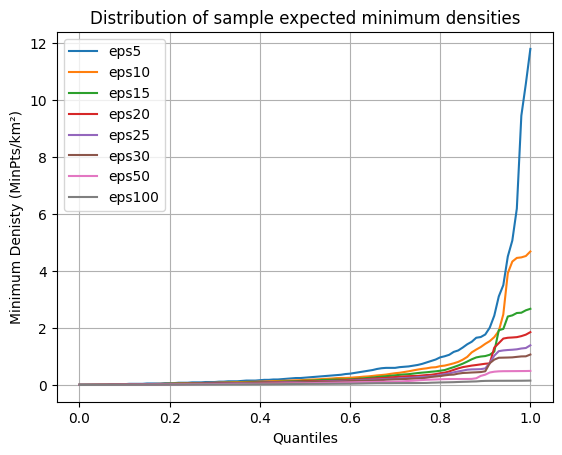

In [95]:
minden.plot()
plt.title('Distribution of sample expected minimum densities')
plt.grid(True)
plt.xlabel('Quantiles')
plt.ylabel('Minimum Denisty (MinPts/km²)')
plt.savefig('plots/fig3a_den_pats_eps.png')
plt.show()

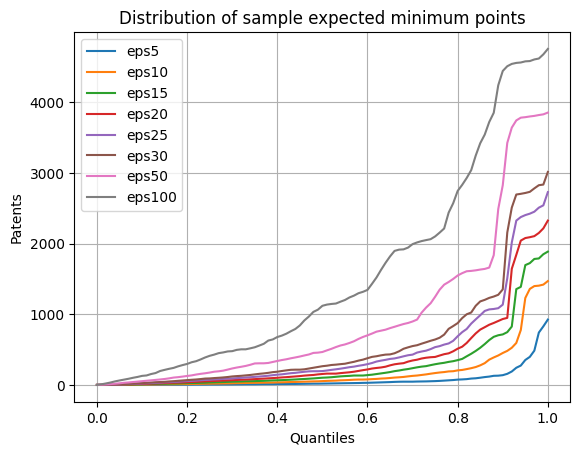

In [94]:
minpts.plot()
plt.title('Distribution of sample expected minimum points')
plt.grid(True)
plt.xlabel('Quantiles')
plt.ylabel('Patents')
plt.savefig('plots/fig3c_pts_pats_eps.png')
plt.show()

In [95]:
nobswgt = x.wgt.sum()
nobswgt

410259.0

In [96]:
limeps = 60 
restmp = pd.DataFrame(columns = ['epsilon', 'radius', 'minden', 'minpts', 'n_clusters', 'cluster_share', 'conc_coeff'])
for myeps in range(1, limeps+1, 1) : 
    radius = myeps /r_km    
    N=tree.query_radius(x[['radlat','radlng']], r=radius, count_only=True)
    x['minden']=(N/np.pi/(myeps**2)).tolist()
    wdf0 = DescrStatsW(x.minden, weights=x.wgt, ddof=1)
    curminden = wdf0.quantile([0.50]).values[0] 
    x['minpts']=N.tolist()
    wdf = DescrStatsW(x.minpts, weights=x.wgt, ddof=1)
    curminpts = int(np.ceil(wdf.quantile([0.50])))
    db = DBSCAN(eps=radius, min_samples=curminpts, algorithm='ball_tree', metric='haversine').fit(x[['radlat','radlng']], sample_weight=x.wgt)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    # n_noise = list(labels).count(-1)
    x['labels']=labels.tolist()
    n_noise = x[x['labels']==-1].wgt.sum()
    noise_share = (n_noise/nobswgt)*100
    cluster_share = 100-noise_share
    conc_coeff = (cluster_share/(50))-1
    print(myeps, radius, curminden, curminpts, n_clusters, cluster_share, conc_coeff)
    restmp = pd.concat([restmp, pd.DataFrame.from_records([{
        'epsilon' : myeps, 
        'radius': radius, 
        'minden': curminden, 
        'minpts' : curminpts, 
        'n_clusters' : n_clusters, 
        'cluster_share' : cluster_share/100,
        'conc_coeff' : conc_coeff}])], ignore_index = True)
        

1 0.0001567855942887398 0.954929658551372 3 19992 84.65164688647903 0.6930329377295805
2 0.0003135711885774796 0.477464829275686 6 7628 82.25218703306936 0.6450437406613871
3 0.0004703567828662194 0.353677651315323 10 3728 81.44927960142252 0.6289855920284504
4 0.0006271423771549592 0.2984155182973038 15 2166 81.42856098220881 0.6285712196441762
5 0.000783927971443699 0.25464790894703254 20 1435 81.81148981497054 0.6362297962994108
6 0.0009407135657324388 0.22989047335495993 26 1056 82.08424434320759 0.6416848868641518
7 0.0010974991600211786 0.20787584403839393 32 831 82.54614767744279 0.6509229535488559
8 0.0012542847543099184 0.19397008689324743 39 664 82.71652785191793 0.6543305570383586
9 0.0014110703485986583 0.1846983290202242 47 554 82.77527123110035 0.6555054246220069
10 0.001567855942887398 0.17507043740108486 55 488 83.00926975398468 0.6601853950796936
11 0.0017246415371761378 0.16836225384927772 64 425 82.98148242939217 0.6596296485878435
12 0.0018814271314648776 0.16136542

In [111]:
respats = restmp

In [131]:
respats.head()

,epsilon,radius,minden,minpts,n_clusters,cluster_share,conc_coeff
0,1,0.000157,0.954930,3,19992,0.846516,0.693033
1,2,0.000314,0.477465,6,7628,0.822522,0.645044
2,3,0.000470,0.353678,10,3728,0.814493,0.628986
3,4,0.000627,0.298416,15,2166,0.814286,0.628571
4,5,0.000784,0.254648,20,1435,0.818115,0.636230


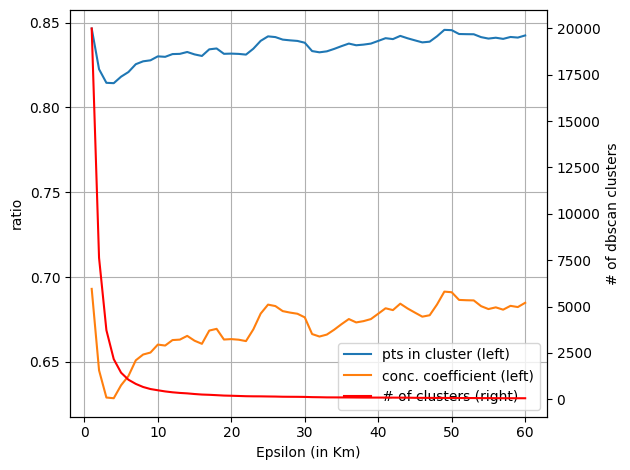

In [132]:
fig = plt.figure()
ax = fig.add_subplot(111)

lns1 = ax.plot(respats['epsilon'], respats['cluster_share'], '-', label = 'pts in cluster (left)')
lns2 = ax.plot(respats['epsilon'], respats['conc_coeff'], '-', label = 'conc. coefficient (left)')
ax2 = ax.twinx()
lns3 = ax2.plot(respats['epsilon'], respats['n_clusters'], '-r', label = '# of clusters (right)')

# added these three lines
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
ax.grid()
ax.set_xlabel("Epsilon (in Km)")
ax.set_ylabel('ratio')
ax2.set_ylabel('# of dbscan clusters')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.savefig('plots/fig3d_pts_pubs_eps.png')
plt.show()

<Figure size 640x480 with 0 Axes>

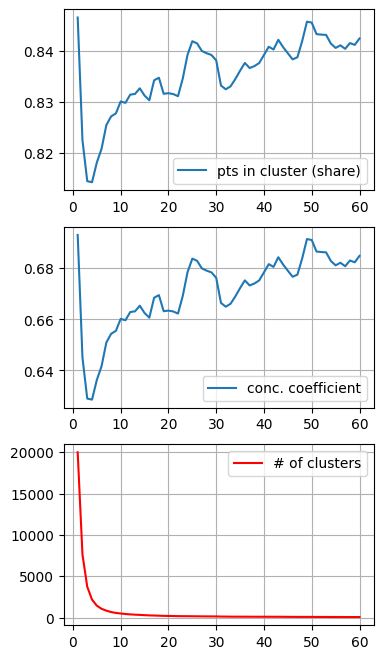

In [133]:
fig = plt.figure()
plt.figure(figsize=(4, 8))
plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.subplot(3,1,1)
plt.plot(respats['epsilon'], respats['cluster_share'], '-', label = 'pts in cluster (share)')
plt.grid()
plt.legend()
plt.subplot(3,1,2)
plt.plot(respats['epsilon'], respats['conc_coeff'], '-', label = 'conc. coefficient')
plt.grid()
plt.legend()
plt.subplot(3,1,3)
plt.plot(respats['epsilon'], respats['n_clusters'], '-r', label = '# of clusters')
plt.grid()
plt.legend()
# plt.savefig('plots/fig3d_pts_pubs_eps.png')
plt.show()

In [25]:
for myeps in range(1, 60+1, 1) : 
    radius = myeps /r_km    
    N=tree.query_radius(x[['radlat','radlng']], r=radius, count_only=True)
    x['minden']=(N/np.pi/(myeps**2)).tolist()
    wdf0 = DescrStatsW(x.minden, weights=x.wgt, ddof=1)
    curminden = wdf0.quantile([0.50]).values[0] 
    x['minpts']=N.tolist()
    wdf = DescrStatsW(x.minpts, weights=x.wgt, ddof=1)
    curminpts = int(np.ceil(wdf.quantile([0.50])))
    db = DBSCAN(eps=radius, min_samples=curminpts, algorithm='ball_tree', metric='haversine').fit(x[['radlat','radlng']], sample_weight=x.wgt)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    # n_noise = list(labels).count(-1)
    x['labels']=labels.tolist()
    n_noise = x[x['labels']==-1].wgt.sum()
    noise_share = (n_noise/nobswgt)*100
    cluster_share = 100-noise_share
    conc_coeff = (cluster_share/(50))-1
    print(myeps, radius, curminden, curminpts, n_clusters, cluster_share, conc_coeff)
    

1 0.0001567855942887398 0.954929658551372 3 19992 84.65164688647903 0.6930329377295805
2 0.0003135711885774796 0.477464829275686 6 7628 82.25218703306936 0.6450437406613871
3 0.0004703567828662194 0.353677651315323 10 3728 81.44927960142252 0.6289855920284504
4 0.0006271423771549592 0.2984155182973038 15 2166 81.42856098220881 0.6285712196441762
5 0.000783927971443699 0.25464790894703254 20 1435 81.81148981497054 0.6362297962994108
6 0.0009407135657324388 0.22989047335495993 26 1056 82.08424434320759 0.6416848868641518
7 0.0010974991600211786 0.20787584403839393 32 831 82.54614767744279 0.6509229535488559
8 0.0012542847543099184 0.19397008689324743 39 664 82.71652785191793 0.6543305570383586
9 0.0014110703485986583 0.1846983290202242 47 554 82.77527123110035 0.6555054246220069
10 0.001567855942887398 0.17507043740108486 55 488 83.00926975398468 0.6601853950796936
11 0.0017246415371761378 0.16836225384927772 64 425 82.98148242939217 0.6596296485878435
12 0.0018814271314648776 0.16136542

## CC

**RE do using same minden for all countries but checking the impact of different eps** 

In [12]:
# count neighbors within given EPS
for c in 'AR','AU','CN','FR','SG','US': # 
    print(c)
    x = dfcc[(dfcc['year']==2013) & (dfcc['cc']==c)].copy()
    tree = BallTree(x[['radlat','radlng']], leaf_size=10, metric='haversine', sample_weight=x.wgt)
    
    for myeps in 10, 20, 50 : 
        print(myeps)
        radius = myeps /r_km    
        N=tree.query_radius(x[['radlat','radlng']], r=radius, count_only=True)
        x['minden']=(N/np.pi/(myeps**2)).tolist()
        wdf = DescrStatsW(x.minden, weights=x.wgt, ddof=1) 
        curminden = pd.DataFrame(wdf.quantile(np.linspace(0,1,101)))
        curminden.rename(columns={0:c+str(myeps)}, inplace=True)
        try:
            tmp = pd.concat([tmp,curminden], axis=1)
        except:
            tmp  = curminden
minden = tmp
del tmp

AR
10
20
50
AU
10
20
50
CN
10
20
50
FR
10
20
50
SG
10
20
50
US
10
20
50


In [13]:
minden. head()

,AR10,AR20,AR50,AU10,AU20,AU50,CN10,CN20,CN50,FR10,FR20,FR50,SG10,SG20,SG50,US10,US20,US50
p,,,,,,,,,,,,,,,,,,
0.00,0.039789,0.014469,0.006631,0.039789,0.014469,0.006631,0.039789,0.014469,0.006631,0.039789,0.014469,0.006631,0.119366,0.390653,0.404519,0.039789,0.014469,0.006631
0.01,0.039789,0.014469,0.006631,0.039789,0.014469,0.013263,0.039789,0.028937,0.019894,0.039789,0.028937,0.053052,0.198944,0.737900,0.404519,0.039789,0.028937,0.026526
0.02,0.039789,0.014469,0.006631,0.039789,0.028937,0.026526,0.079577,0.043406,0.033157,0.079577,0.057875,0.066315,1.989437,0.824712,0.404519,0.039789,0.043406,0.033157
0.03,0.039789,0.014469,0.006631,0.039789,0.028937,0.026526,0.079577,0.057875,0.033157,0.079577,0.057875,0.066315,1.989437,0.824712,0.404519,0.079577,0.043406,0.046420
0.04,0.039789,0.014469,0.013263,0.079577,0.043406,0.039789,0.119366,0.072343,0.039789,0.119366,0.057875,0.072946,2.029226,0.824712,0.404519,0.079577,0.057875,0.059683


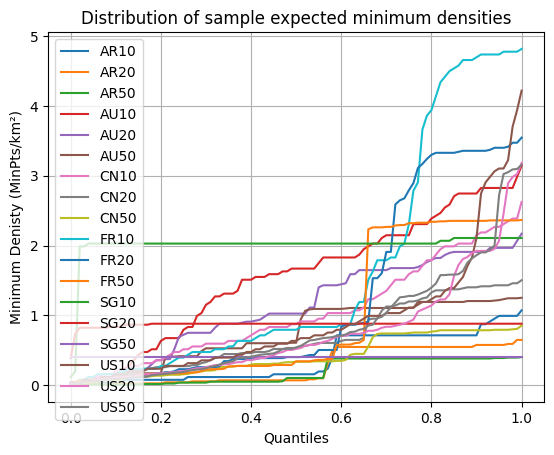

In [14]:
minden.plot()
plt.title('Distribution of sample expected minimum densities')
plt.grid(True)
plt.xlabel('Quantiles')
plt.ylabel('Minimum Denisty (MinPts/km²)')
plt.legend(loc='upper left')
plt.show()

In [15]:
nobswgt = x.wgt.sum()
nobswgt

351651.0

In [28]:
# loop within percentiles
myeps = 15
for i in 25, 50, 75, 90:
    print(i, "...", end = '')
    minpts = math.ceil(wdf.quantile([i/100]).values[0])
    np.percentile(N, i, axis=0)    
    db = DBSCAN(eps=myeps/r_km, min_samples=minpts, algorithm='ball_tree', metric='haversine').fit(x[['radlat','radlng']], sample_weight=x.wgt)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    # n_noise = list(labels).count(-1)
    x['labels']=labels.tolist()
    n_noise = x[x['labels']==-1].wgt.sum()
    noise_share = (n_noise/nobswgt)*100
    cluster_share = 100-noise_share
    conc_coeff = (cluster_share/(100-i))-1
    silhout=None # too slow
    # try: 
    #     silhout=metrics.silhouette_score(df_sample[['radlat','radlng']], labels, metric='haversine')
    # except:
    #     silhout=None
    curdata = pd.DataFrame({'pctile':[i],'neighbors':[minpts],'cluster_share':[cluster_share],'conc_coeff':[conc_coeff],
            'silhout':[silhout],'n_clusters':[n_clusters],'n_noise':[n_noise], 'noise_share':[noise_share]})
    if i==1:
        df_pctiles = curdata
    else:
        df_pctiles=pd.concat((df_pctiles, curdata), ignore_index=True, axis=0)
print( "Done!")
df_pctiles.head()

25 ...50 ...75 ...90 ...Done!


,pctile,neighbors,cluster_share,conc_coeff,silhout,n_clusters,n_noise,noise_share
0,1,1,100.0,0.010101,None,381,0.0,0.0
1,2,1,100.0,0.020408,None,381,0.0,0.0
2,3,1,100.0,0.030928,None,381,0.0,0.0
3,4,1,100.0,0.041667,None,381,0.0,0.0
4,5,1,100.0,0.052632,None,381,0.0,0.0


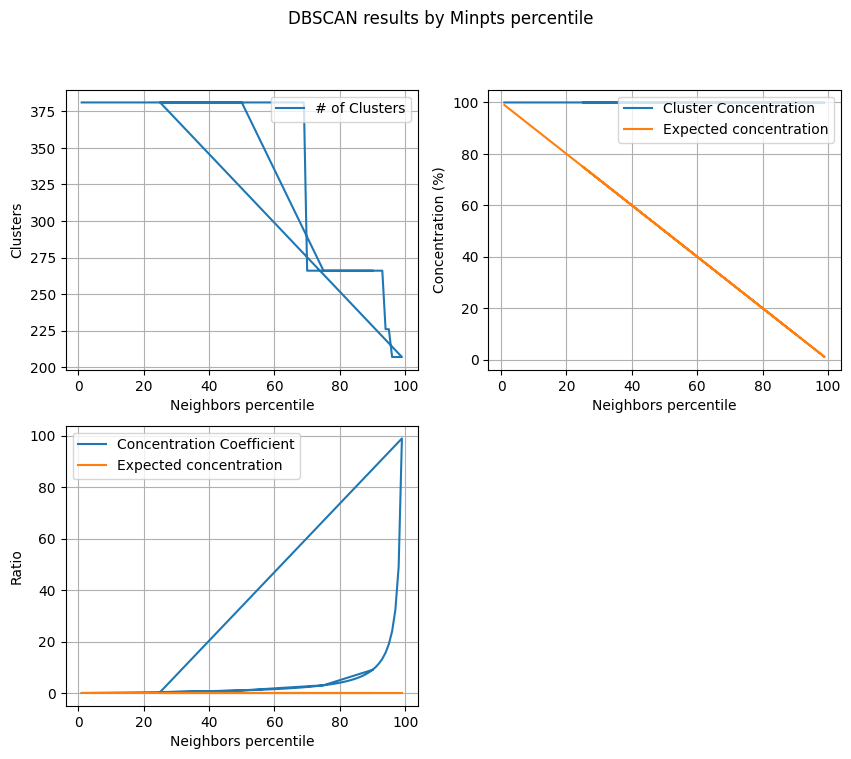

In [31]:
dfplt=df_pctiles[df_pctiles['n_clusters']>0]
plt.figure(figsize=(10, 8))
plt.suptitle('DBSCAN results by Minpts percentile')
plt.subplot(2,2,1)
plt.plot(dfplt['pctile'], dfplt['n_clusters'], label = "# of Clusters")
plt.xlabel('Neighbors percentile')
plt.ylabel('Clusters')
plt.legend(loc='upper right')
plt.grid(True)
plt.subplot(2,2,2)
plt.plot(dfplt['pctile'], dfplt['cluster_share'], label = "Cluster Concentration")
plt.plot(dfplt['pctile'], 100- dfplt['pctile'], label = "Expected concentration")
plt.xlabel('Neighbors percentile')
plt.ylabel('Concentration (%)')
plt.legend(loc='upper right')
plt.grid(True)
plt.subplot(2,2,3)
plt.plot(dfplt['pctile'], dfplt['conc_coeff'], label = "Concentration Coefficient")
plt.plot(dfplt['pctile'], dfplt['pctile']-dfplt['pctile'], label = "Expected concentration")
plt.xlabel('Neighbors percentile')
plt.ylabel('Ratio')
plt.legend(loc='upper left')
plt.grid(True)
plt.savefig('plots/'+str(myeps)+'results.png')
plt.show()

<AxesSubplot: title={'center': 'Scientific articles (2003)'}, xlabel='lng', ylabel='lat'>

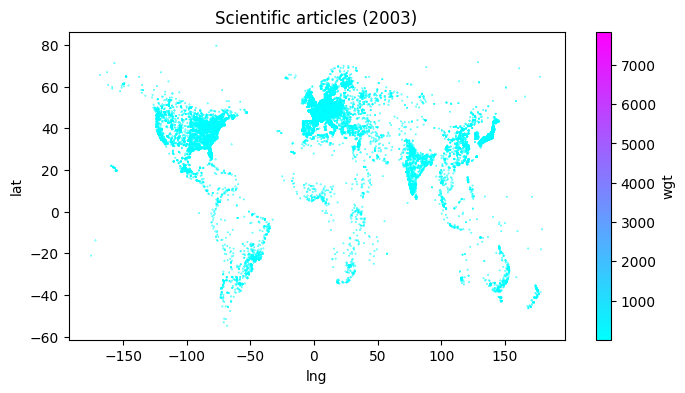

In [153]:
dfall[dfall['year']==2003].plot(x="lng", y="lat", kind="scatter", s=.1, figsize=[8,4], title='Scientific articles (2003)', c='wgt',colormap='cool')

<AxesSubplot: title={'center': 'Scientific articles (2013)'}, xlabel='lng', ylabel='lat'>

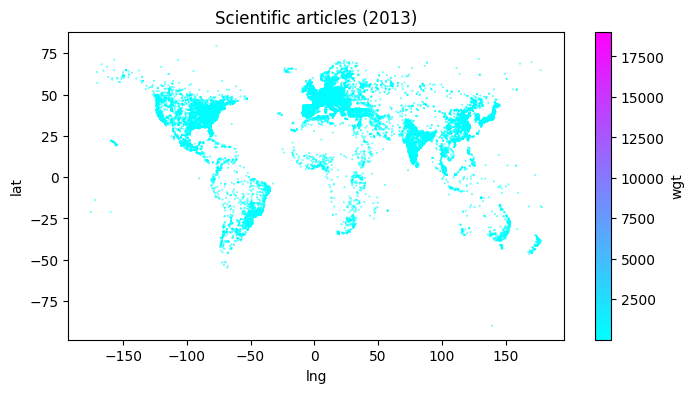

In [154]:
dfall[dfall['year']==2013].plot(x="lng", y="lat", kind="scatter", s=.1, figsize=[8,4], title='Scientific articles (2013)', c='wgt',colormap='cool')

In [155]:
r_km = 6378.137 # 6371 # multiplier to convert to km (from unit distance)

In [156]:
x = dfall[dfall['year']==2013]
nn = NearestNeighbors(n_neighbors=2, algorithm='ball_tree', metric='haversine').fit(x[['radlat','radlng']])
distances, idx = nn.kneighbors(x[['radlat','radlng']])
distances = np.sort(distances, axis=0)
distances = distances[:,1]
distances_km=distances*r_km
distances_km

array([6.21120888e-04, 6.21120888e-04, 6.46660160e-04, ...,
       1.51358318e+03, 1.75524193e+03, 3.91868290e+03])

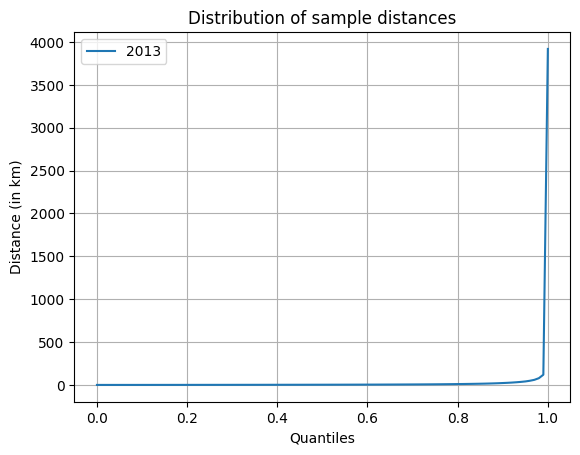

In [157]:
i = pd.DataFrame(distances_km).quantile(np.linspace(0,1,101))
i.rename(columns={0:'2013'}, inplace=True)
i.plot()
plt.title('Distribution of sample minimum distances')
plt.grid(True)
plt.xlabel('Quantiles')
plt.ylabel('Distance (in km)')
plt.show()

In [158]:
x = dfall[dfall['year']==2003]
nn = NearestNeighbors(n_neighbors=2, algorithm='ball_tree', metric='haversine').fit(x[['radlat','radlng']])
distances, idx = nn.kneighbors(x[['radlat','radlng']])
distances = np.sort(distances, axis=0)
distances = distances[:,1]
distances_km=distances*r_km
distances_km

array([4.29947093e-04, 4.29947093e-04, 6.21120888e-04, ...,
       1.42066947e+03, 1.90011239e+03, 1.94240481e+03])

In [159]:
j = pd.DataFrame(distances_km).quantile(np.linspace(0,1,101))
j.rename(columns={0:'2003'}, inplace=True)
i = pd.concat([i,j], axis=1)

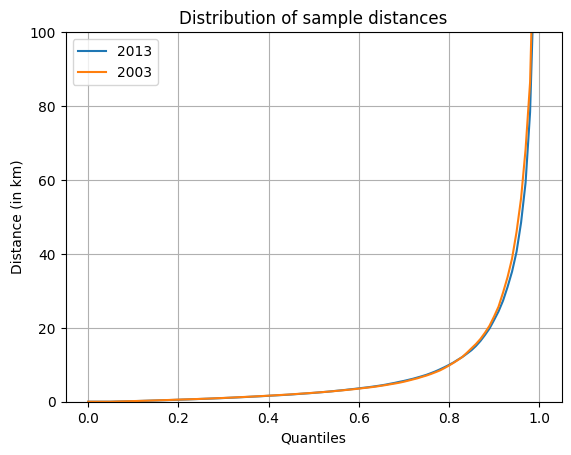

In [160]:
i.plot()
plt.title('Distribution of sample minimum distances')
plt.grid(True)
plt.xlabel('Quantiles')
plt.ylim((0,100))
plt.ylabel('Distance (in km)')
plt.show()

In [161]:
x = df[df['year']==2013]
for t in x.tec.unique():
    z=x[x['tec']==t]
    print(t,':', z.wgt.sum())
    nn = NearestNeighbors(n_neighbors=2, algorithm='ball_tree', metric='haversine').fit(z[['radlat','radlng']])
    distances, idx = nn.kneighbors(z[['radlat','radlng']])
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    distances_km=distances*r_km
    distances_km
    j = pd.DataFrame(distances_km).quantile(np.linspace(0,1,101))
    j.rename(columns={0:str(t)}, inplace=True)
    i = pd.concat([i,j], axis=1)

9 : 165613.0
1 : 123070.0
2 : 120726.0
4 : 199489.0
5 : 105508.0
7 : 110375.0
8 : 120386.0
10 : 110002.0
12 : 100163.0
3 : 205390.0
6 : 134676.0
11 : 121428.0
0 : 1471.0


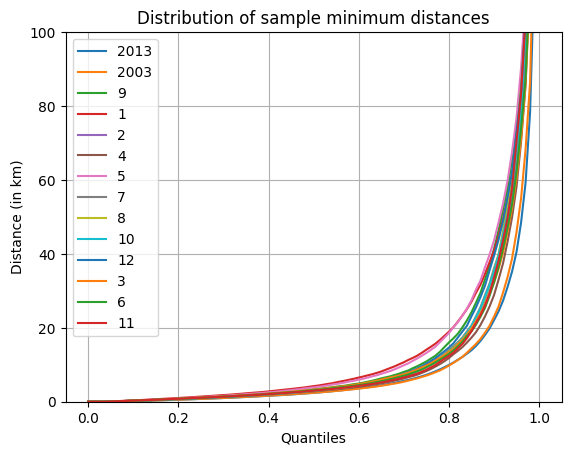

In [166]:
p=i.drop(columns=['0'])
p.plot()
plt.title('Distribution of sample minimum distances')
plt.grid(True)
plt.xlabel('Quantiles')
plt.ylim((0,100))
plt.ylabel('Distance (in km)')
plt.show()

# Pats
## 35 tecs

In [14]:
df = pd.read_csv('ipf0313.csv')
df.head()

,year,lat,lng,tec,wgt
0,2003,-46.40000,168.35001,1409,0.250000
1,2003,-46.40000,168.35001,3220,0.250000
2,2003,-46.23148,169.75117,3429,0.500000
3,2003,-46.23148,169.75117,4125,0.500000
4,2003,-46.13330,167.68300,4227,0.166667


In [25]:
dfall = df.groupby(['year','lat','lng'],as_index=False).sum()
dfall = dfall.drop(columns = ['tec'])
dfall.head()

,year,lat,lng,wgt
0,2003,-46.40000,168.35001,0.500000
1,2003,-46.23148,169.75117,1.000000
2,2003,-46.13330,167.68300,0.333333
3,2003,-46.09880,168.94600,0.333333
4,2003,-46.08330,168.05000,0.333333


In [27]:
for x in df, dfall:
    # round up wgts
    x['wgt']=x['wgt'].apply(np.ceil)
    # convert coords to radians 
    x['radlat']=np.deg2rad(x['lat'].values)
    x['radlng']=np.deg2rad(x['lng'].values)
    print(x.head())
    print('total wgts:', x.wgt.sum())
    # print('unwgt stats:', x.describe())

   year       lat        lng   tec  wgt    radlat    radlng
0  2003 -46.40000  168.35001  1409  1.0 -0.809833  2.938262
1  2003 -46.40000  168.35001  3220  1.0 -0.809833  2.938262
2  2003 -46.23148  169.75117  3429  1.0 -0.806892  2.962717
3  2003 -46.23148  169.75117  4125  1.0 -0.806892  2.962717
4  2003 -46.13330  167.68300  4227  1.0 -0.805178  2.926620
total wgts: 1271325.0
   year       lat        lng  wgt    radlat    radlng
0  2003 -46.40000  168.35001  1.0 -0.809833  2.938262
1  2003 -46.23148  169.75117  1.0 -0.806892  2.962717
2  2003 -46.13330  167.68300  1.0 -0.805178  2.926620
3  2003 -46.09880  168.94600  1.0 -0.804576  2.948664
4  2003 -46.08330  168.05000  1.0 -0.804305  2.933026
total wgts: 712833.0


<AxesSubplot: title={'center': 'Patent families (2003)'}, xlabel='lng', ylabel='lat'>

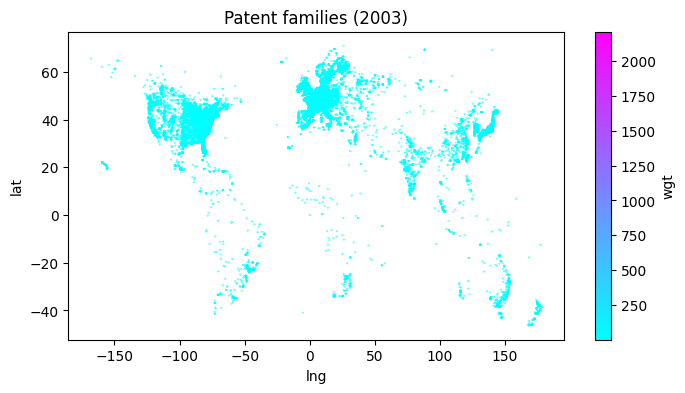

In [33]:
dfall[dfall['year']==2003].plot(x="lng", y="lat", kind="scatter", s=.1, figsize=[8,4], title='Patent families (2003)', c='wgt',colormap='cool')

<AxesSubplot: title={'center': 'Patent families (2013)'}, xlabel='lng', ylabel='lat'>

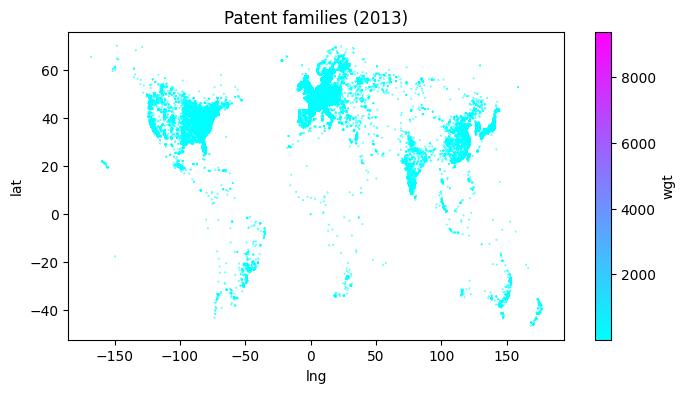

In [35]:
dfall[dfall['year']==2013].plot(x="lng", y="lat", kind="scatter", s=.1, figsize=[8,4], title='Patent families (2013)', c='wgt',colormap='cool')

In [36]:
r_km = 6378.137 # 6371 # multiplier to convert to km (from unit distance)

In [137]:
x = dfall[dfall['year']==2013]
nn = NearestNeighbors(n_neighbors=2, algorithm='ball_tree', metric='haversine').fit(x[['radlat','radlng']])
distances, idx = nn.kneighbors(x[['radlat','radlng']])
distances = np.sort(distances, axis=0)
distances = distances[:,1]
distances_km=distances*r_km
distances_km

array([6.28682714e-04, 6.28682714e-04, 6.35183012e-04, ...,
       1.30940903e+03, 1.53791004e+03, 3.97487026e+03])

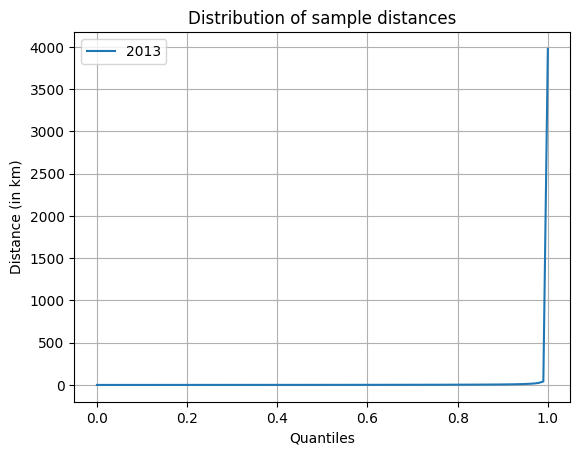

In [138]:
i = pd.DataFrame(distances_km).quantile(np.linspace(0,1,101))
i.rename(columns={0:'2013'}, inplace=True)
i.plot()
plt.title('Distribution of sample distances')
plt.grid(True)
plt.xlabel('Quantiles')
plt.ylabel('Distance (in km)')
plt.show()

In [139]:
x = dfall[dfall['year']==2003]
nn = NearestNeighbors(n_neighbors=2, algorithm='ball_tree', metric='haversine').fit(x[['radlat','radlng']])
distances, idx = nn.kneighbors(x[['radlat','radlng']])
distances = np.sort(distances, axis=0)
distances = distances[:,1]
distances_km=distances*r_km
distances_km

array([6.37615588e-04, 6.37615588e-04, 6.58036050e-04, ...,
       1.27549000e+03, 1.92358183e+03, 2.19652783e+03])

In [140]:
j = pd.DataFrame(distances_km).quantile(np.linspace(0,1,101))
j.rename(columns={0:'2003'}, inplace=True)
i = pd.concat([i,j], axis=1)

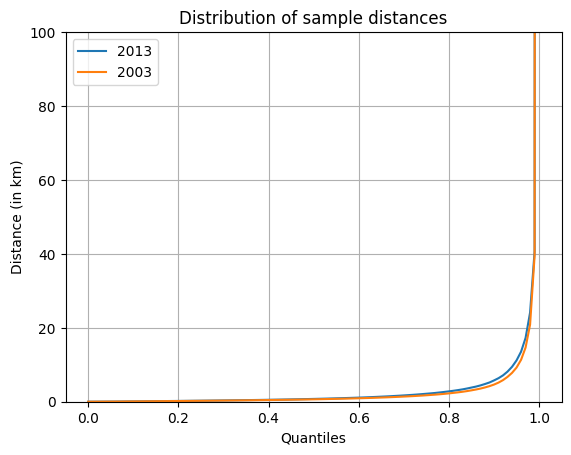

In [141]:
i.plot()
plt.title('Distribution of sample minimum distances')
plt.grid(True)
plt.xlabel('Quantiles')
plt.ylim((0,100))
plt.ylabel('Distance (in km)')
plt.show()

In [142]:
x = df[df['year']==2013]
for t in x.tec.unique():
    z=x[x['tec']==t]
    print(t,':', z.wgt.sum())
    nn = NearestNeighbors(n_neighbors=2, algorithm='ball_tree', metric='haversine').fit(z[['radlat','radlng']])
    distances, idx = nn.kneighbors(z[['radlat','radlng']])
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    distances_km=distances*r_km
    distances_km
    j = pd.DataFrame(distances_km).quantile(np.linspace(0,1,101))
    j.rename(columns={0:str(t)}, inplace=True)
    i = pd.concat([i,j], axis=1)

3220 : 13954.0
3324 : 10428.0
3419 : 19596.0
4230 : 10872.0
2113 : 31334.0
0 : 18047.0
5135 : 18715.0
5233 : 12727.0
2111 : 9905.0
3114 : 19423.0
3115 : 18689.0
1101 : 42815.0
1408 : 24454.0
2110 : 31427.0
4125 : 16787.0
3221 : 16302.0
1306 : 50444.0
3116 : 24165.0
3429 : 22098.0
1303 : 20098.0
1304 : 34658.0
1409 : 20945.0
3118 : 7884.0
1307 : 12912.0
4227 : 20502.0
4231 : 21450.0
1202 : 26067.0
1305 : 7357.0
2112 : 16313.0
4232 : 27941.0
5234 : 13030.0
4126 : 14581.0
3417 : 13352.0
3323 : 19002.0
4128 : 10067.0
3222 : 3812.0


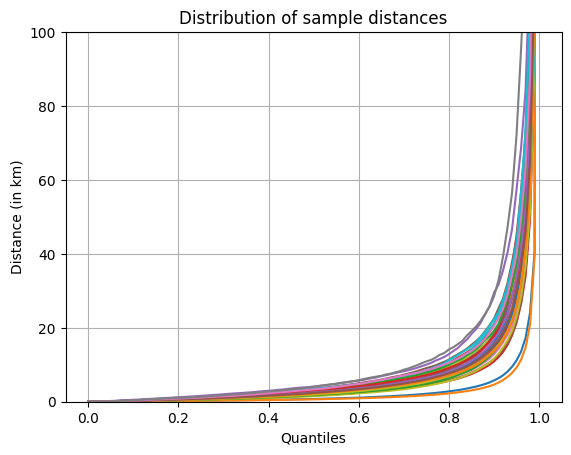

In [148]:
i.plot()
plt.title('Distribution of sample minimum distances')
plt.grid(True)
plt.xlabel('Quantiles')
plt.ylim((0,100))
plt.ylabel('Distance (in km)')
legend = plt.legend([])
legend.remove()
# plt.get_legend().remove()
plt.show()

## 13 Subsectors

In [168]:
df = pd.read_csv('ipf0313tec2.csv')
df.rename(columns={'tec2': 'tec'}, inplace=True)
df.head()

,year,lat,lng,tec,wgt
0,2003,-46.40000,168.35001,14,0.250000
1,2003,-46.40000,168.35001,32,0.250000
2,2003,-46.23148,169.75117,34,0.500000
3,2003,-46.23148,169.75117,41,0.500000
4,2003,-46.13330,167.68300,42,0.333333


In [169]:
dfall = df.groupby(['year','lat','lng'],as_index=False).sum()
dfall = dfall.drop(columns = ['tec'])
dfall.head()

,year,lat,lng,wgt
0,2003,-46.40000,168.35001,0.500000
1,2003,-46.23148,169.75117,1.000000
2,2003,-46.13330,167.68300,0.333333
3,2003,-46.09880,168.94600,0.333333
4,2003,-46.08330,168.05000,0.333333


In [170]:
for x in df, dfall:
    # round up wgts
    x['wgt']=x['wgt'].apply(np.ceil)
    # convert coords to radians 
    x['radlat']=np.deg2rad(x['lat'].values)
    x['radlng']=np.deg2rad(x['lng'].values)
    print(x.head())
    print('total wgts:', x.wgt.sum())
    # print('unwgt stats:', x.describe())

   year       lat        lng  tec  wgt    radlat    radlng
0  2003 -46.40000  168.35001   14  1.0 -0.809833  2.938262
1  2003 -46.40000  168.35001   32  1.0 -0.809833  2.938262
2  2003 -46.23148  169.75117   34  1.0 -0.806892  2.962717
3  2003 -46.23148  169.75117   41  1.0 -0.806892  2.962717
4  2003 -46.13330  167.68300   42  1.0 -0.805178  2.926620
total wgts: 1037548.0
   year       lat        lng  wgt    radlat    radlng
0  2003 -46.40000  168.35001  1.0 -0.809833  2.938262
1  2003 -46.23148  169.75117  1.0 -0.806892  2.962717
2  2003 -46.13330  167.68300  1.0 -0.805178  2.926620
3  2003 -46.09880  168.94600  1.0 -0.804576  2.948664
4  2003 -46.08330  168.05000  1.0 -0.804305  2.933026
total wgts: 712889.0


<AxesSubplot: title={'center': 'Patent families (2003)'}, xlabel='lng', ylabel='lat'>

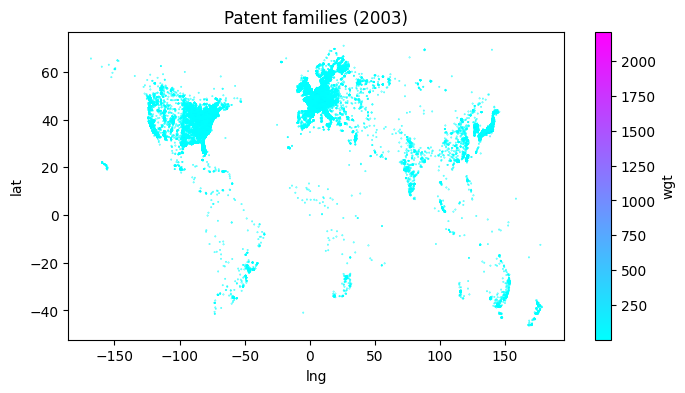

In [171]:
dfall[dfall['year']==2003].plot(x="lng", y="lat", kind="scatter", s=.1, figsize=[8,4], title='Patent families (2003)', c='wgt',colormap='cool')

<AxesSubplot: title={'center': 'Patent families (2013)'}, xlabel='lng', ylabel='lat'>

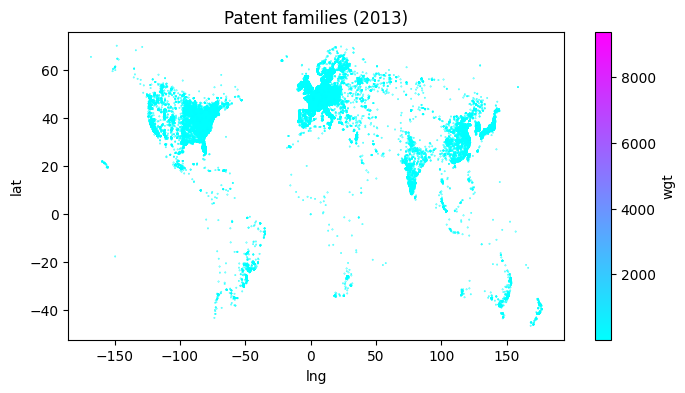

In [172]:
dfall[dfall['year']==2013].plot(x="lng", y="lat", kind="scatter", s=.1, figsize=[8,4], title='Patent families (2013)', c='wgt',colormap='cool')

In [173]:
r_km = 6378.137 # 6371 # multiplier to convert to km (from unit distance)

In [174]:
x = dfall[dfall['year']==2013]
nn = NearestNeighbors(n_neighbors=2, algorithm='ball_tree', metric='haversine').fit(x[['radlat','radlng']])
distances, idx = nn.kneighbors(x[['radlat','radlng']])
distances = np.sort(distances, axis=0)
distances = distances[:,1]
distances_km=distances*r_km
distances_km

array([6.28682714e-04, 6.28682714e-04, 6.35183012e-04, ...,
       1.30940903e+03, 1.53791004e+03, 3.97487026e+03])

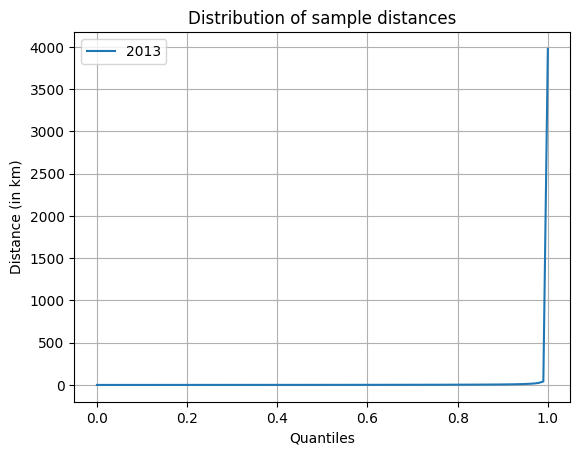

In [175]:
i = pd.DataFrame(distances_km).quantile(np.linspace(0,1,101))
i.rename(columns={0:'2013'}, inplace=True)
i.plot()
plt.title('Distribution of sample distances')
plt.grid(True)
plt.xlabel('Quantiles')
plt.ylabel('Distance (in km)')
plt.show()

In [176]:
x = dfall[dfall['year']==2003]
nn = NearestNeighbors(n_neighbors=2, algorithm='ball_tree', metric='haversine').fit(x[['radlat','radlng']])
distances, idx = nn.kneighbors(x[['radlat','radlng']])
distances = np.sort(distances, axis=0)
distances = distances[:,1]
distances_km=distances*r_km
distances_km

array([6.37615588e-04, 6.37615588e-04, 6.58036050e-04, ...,
       1.27549000e+03, 1.92358183e+03, 2.19652783e+03])

In [177]:
j = pd.DataFrame(distances_km).quantile(np.linspace(0,1,101))
j.rename(columns={0:'2003'}, inplace=True)
i = pd.concat([i,j], axis=1)

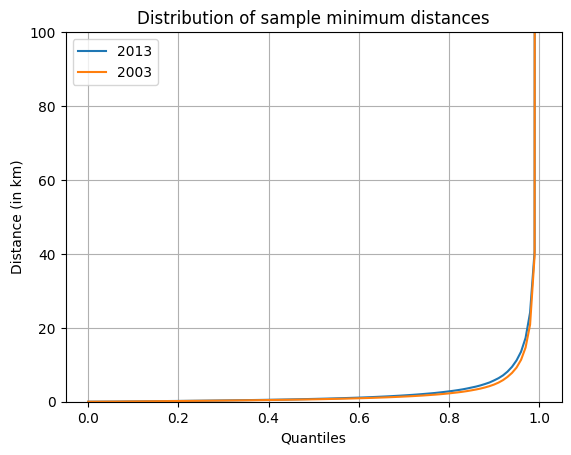

In [178]:
i.plot()
plt.title('Distribution of sample minimum distances')
plt.grid(True)
plt.xlabel('Quantiles')
plt.ylim((0,100))
plt.ylabel('Distance (in km)')
plt.show()

In [179]:
x = df[df['year']==2013]
for t in x.tec.unique():
    z=x[x['tec']==t]
    print(t,':', z.wgt.sum())
    nn = NearestNeighbors(n_neighbors=2, algorithm='ball_tree', metric='haversine').fit(z[['radlat','radlng']])
    distances, idx = nn.kneighbors(z[['radlat','radlng']])
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    distances_km=distances*r_km
    distances_km
    j = pd.DataFrame(distances_km).quantile(np.linspace(0,1,101))
    j.rename(columns={0:str(t)}, inplace=True)
    i = pd.concat([i,j], axis=1)

32 : 27517.0
33 : 24990.0
34 : 41979.0
42 : 65124.0
21 : 69541.0
0 : 18047.0
51 : 18715.0
52 : 23280.0
31 : 48375.0
11 : 42815.0
14 : 41140.0
41 : 35786.0
13 : 96768.0
12 : 26067.0


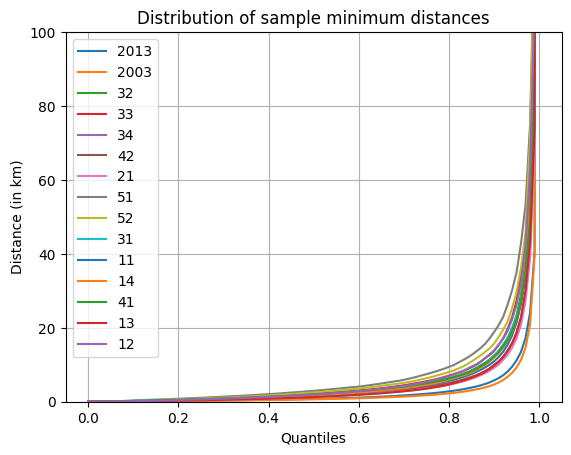

In [182]:
p=i.drop(columns=['0'])
p.plot()
plt.title('Distribution of sample minimum distances')
plt.grid(True)
plt.xlabel('Quantiles')
plt.ylim((0,100))
plt.ylabel('Distance (in km)')
plt.show()